# :satellite: Clasificación de rocas espaciales mediante Python e inteligencia artificial :last_quarter_moon:


In [1]:
# AI model to classify space rocks
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image


In [2]:
#  libraries that ensure that paths are displayed inserted and in high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# contains the image data
data_dir = './Data'

# Read the data, crop and resize the images, 
# split data into two groups: test and train
def load_split_train_test(data_dir, valid_size = .2):

    # Transform the images to train the model
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),    
        ])
    
    # Transform the images to test model
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Create two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Get the number of images in the training folder
    num_train = len(train_data)

    # Create a list 
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2
    split = int(np.floor(valid_size * num_train))

    # Random shuffle the indices
    # For 10 images, an example would be that indices is now the list [2,5,4,6,7,1,3,0,9,8]
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # With the indices randomly shuffled, 
    # grab the first 20% of the shuffled indices, and store them in the training index list
    # grab the remainder of the shuffled indices, and store them in the testing index list
    # Given our example so far, this would result is:
    # train_idx is the list [1,5] 
    # test_idx is the list [4,6,7,1,3,0,9,8]
    train_idx, test_idx = indices[split:], indices[:split]

    # Create samplers to randomly grab items from the training and testing indices list
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create loaders to load 16 images from the train an test data folders
    # Images are choosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader


# Using the function that shuffles images,
# create a trainloader to load 20% of the images
# create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, .2)

print(trainloader.dataset.classes)
# print(testloader.dataset.classes)


['Basalt', 'Highland']


## Adding code to transform and select random images

In [4]:


# Transform an image into pixels and resize it
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Randomly select a set of images by using a similar approach as the load_split_train_test function
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Create an iterator to iterarte over the shuffled images in the test images dataset
    dataiter = iter(loader)

    # Get and return the images and labels from the iterator
    images, labels = dataiter.next()

    return images, labels


## Adding code to display randomly selected images

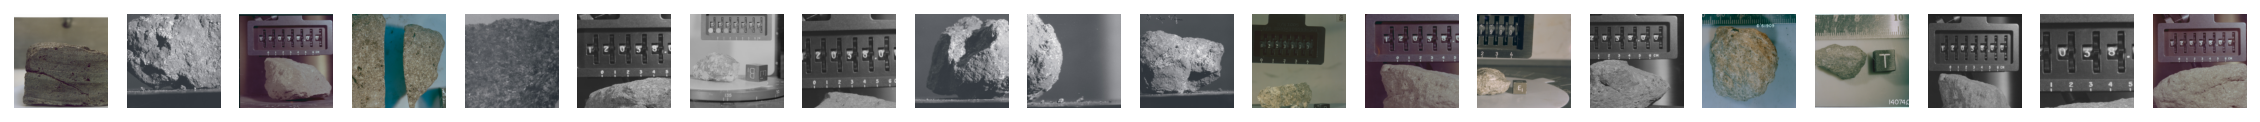

In [12]:


# Show five images 
images, labels = get_random_images(20)

# Convert the array of pixels to an image
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# Get a list of all classes in the training data
classes = trainloader.dataset.classes

# Draw the images in a plot to display in the notebook

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

# Display all of the images
plt.show()

In [13]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

## Creation of neurons and connection of the network

In [14]:
# Build all the neurons
for param in model.parameters():
    param.requires_grad = False

# Wire the neurons together to create the neural network
model.fc = nn.Sequential(
    nn.Linear(2048, 512), 
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
    )

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Add the neural network to the device
model.to(device)

print("done")


done


## Neural network training

In [15]:
# Set the initial number of iter to search for associations
epochs = 10
print_every = 5

# Initialize the loss variables
running_loss = 0
train_losses, test_losses = [], []

# Track the current training step, start at 0
steps = 0

# Search for associations in the features
for epoch in range(epochs):
    epoch += 1

    # Load in all of the image inputs and labels from the TRAIN loader
    for inputs, labels in trainloader:
        steps += 1
        print('Training step ', steps)

        # Load the inputs labels to the already selected device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out gradients to avoid accumulations of gradiants
        optimizer.zero_grad()

        # Pass the images through the model, return the log probabilities of each label
        logps = model.forward(inputs)

        # Run the log images through the criterion to get the output graph
        loss = criterion(logps, labels)
        # Loss graph to compute gradients
        loss.backward()
        # Update parameters based on the current gradient
        optimizer.step()

        running_loss += loss.item()

        # Every n steps, evaluate the model
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            model.eval()

            # Refine the accuracy of prediction without updating the gradients
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()

                    # Return the new tensor with the true probabilities
                    ps = torch.exp(logps)
                    # Return the largest probablility and class of the new tensor along a given dimesion
                    top_p, top_class = ps.topk(1, dim=1)
                    # Reshape the tensor to match the same shape as the top class
                    equals = top_class == labels.view(*top_class.shape)
                    # Compute the accuracy and add it to the running acurracy count for the test batch
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                
                # Append the training and testing losses
                train_losses.append(running_loss / len(trainloader))
                test_losses.append(test_loss / len(testloader))

                # Display the accuracy of the prediction with 3 digits in the fractional part of the decimal
                print(f"\n     Epoch {epoch}/{epochs}: " f"Train loss: {running_loss/print_every:.3f}.. " f"Test loss: {test_loss/len(testloader):.3f}.. " f"Test accuracy: {accuracy/len(testloader):.3f}\n")

                # Train the model
                running_loss = 0
                model.train()

                break



Training step  1
Training step  2
Training step  3
Training step  4
Training step  5

     Epoch 1/10: Train loss: 1.735.. Test loss: 1.973.. Test accuracy: 0.519

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10

     Epoch 2/10: Train loss: 0.895.. Test loss: 0.546.. Test accuracy: 0.806

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15

     Epoch 3/10: Train loss: 0.914.. Test loss: 1.736.. Test accuracy: 0.615

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20

     Epoch 4/10: Train loss: 0.778.. Test loss: 0.581.. Test accuracy: 0.744

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25

     Epoch 5/10: Train loss: 0.381.. Test loss: 0.736.. Test accuracy: 0.744

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30

     Epoch 6/10: Train loss: 0.528.. Test loss: 0.503.. Test accuracy: 0.

## Show model accuracy

In [16]:
print(accuracy / len(testloader))

0.9020833373069763


## Save the model

In [17]:
torch.save(model, 'aerialmodel.pth')

## Make predictions with the model

In [18]:
# load the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')

# Make a function prediction
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()

    return index

## Prediction of rock types from random images

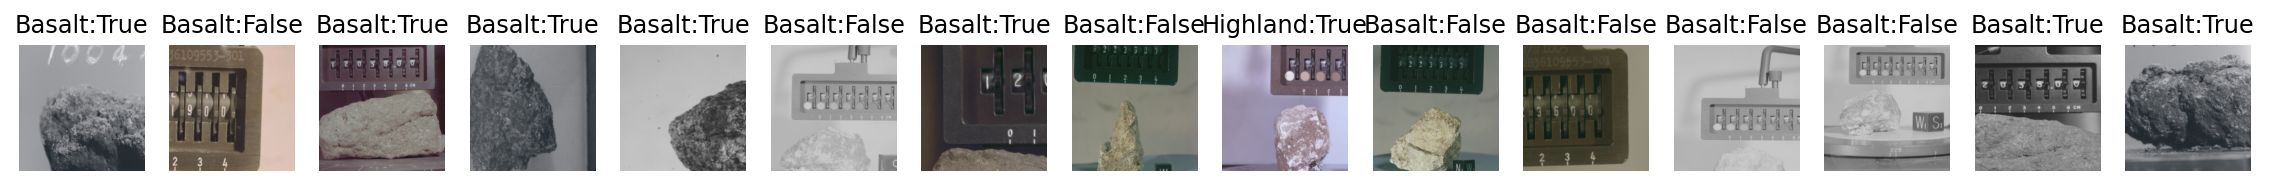

In [20]:
# Get n random images and display them
to_pil = transforms.ToPILImage()
images, labels = get_random_images(15)
fig = plt.figure(figsize=(20, 10))

# Load all of the classes from the training loader
classes = trainloader.dataset.classes

# Loop the randomly selected images
for ii in range(len(images)):
    # Predict the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    # Add the class to the plot
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

plt.show()

# Resumen

En esta lección ha creado un modelo de IA para detectar distintos tipos de rocas espaciales.

* Ha aprendido que las redes neuronales son sistemas de equipo cuyo modelo se basa en el sistema nervioso y el cerebro humano. Ha usado código para crear una red neuronal para el modelo de IA.

* Use los datos de entrenamiento proporcionados para enseñar la red neuronal en su modelo con el fin de predecir con precisión los tipos de rocas espaciales de las fotos.

* Ha descubierto que la precisión de un modelo de inteligencia artificial es la frecuencia con la que el modelo acierta en sus predicciones. La precisión del modelo se puede aumentar agregando más imágenes y épocas durante el entrenamiento.

* Ha revisado los pasos para extraer características de las imágenes para usarlas para las predicciones de inteligencia artificial. Ha usado código para encontrar la precisión del modelo de IA.

* Ha probado el modelo para predecir los tipos de rocas que se muestran en fotos aleatorias.